In [8]:
from llm.LLMModel import *
from llm.LlamaLoader import LlamaLoader, LlamaCpp
from ner.llm_ner.prompt_techniques.pt_multi_pt import PT_Multi_PT, PT_2Time_Tagger
from ner.llm_ner.prompt_techniques.pt_discussion import PT_OutputList
from ner.Datasets.Conll2003Dataset import Conll2003Dataset
from ner.Datasets.MyDataset import MyDataset
from ner.llm_ner.few_shots_techniques import *
%reload_ext autoreload
%autoreload 2
from ner.evaluating_confidence import *

In [ ]:
data_train = MyDataset.my_load_dataset(dataset=Conll2003Dataset, split = 'train', cleaned= True)
data_test =  MyDataset.my_load_dataset(dataset=Conll2003Dataset, split = 'test', cleaned= True)

In [ ]:
model = MistralAI(llm_loader = Llama_LlamaCpp())
fst = FST_Sentence(data_train, 3)
multi_pt = PT_2Time_Tagger(fst)

In [ ]:
sentence = data_test[18]
logits_for_tags, output, index, values = get_logits_for_tags(sentence, model, pt = multi_pt)
logits_for_tags

In [ ]:
generated_tokens = list(model.model.model.eval_tokens)[-output['usage']['completion_tokens']:]
generated_logits = list(model.model.model.eval_logits)[-output['usage']['completion_tokens']:]

In [ ]:
[logits[28753] for logits in generated_logits ]

In [ ]:
logits_for_tags = [{'gold_tag' : gold_tag, 'tags_logits': {tag: generated_logits[idx][mapping_letter_tokens[tag][1]] for tag in mapping_letter_tokens.keys()}} for idx, gold_tag in zip(index,values)]
logits_for_tags

In [ ]:
# Afficher n = 0 et n = 2 où LOC est attendu mais on donne du ORG
n = 2
sentence = data_test[n]['text']
print(data_test[n]['text'])
print(data_test[n]['spans'])
get_logits_for_tags(sentence, model, pt)

In [ ]:
sentence = "Washington is the president of the United States"
sentence_o = " [['Washington', 'LOC'], ['United States', 'LOC']] "
prompt = llama_ner.get_prompts(sentence=sentence, tags = [], n = 0)

output = llm(prompt, stop = ["<end_output>"])

In [ ]:
from ner.evaluating_confidence import get_logits_for_tags
sentences = [
    "Washington is the president of the United States",
    "John is an important person living in Paris"
]
for sent in sentences :
    print(get_logits_for_tags(sent, llm, llama_ner))

In [ ]:
model.model.detokenize([464, 28753, 647])

In [ ]:
# print(model.model.tokenize("'World Cup': 'P'".encode()))'World Cup': 'P'
# print(model.model.tokenize("'World Cup': 'P'".encode()))

print(model.model.tokenize("'World Cup': 'P', ".encode()))
print(model.model.tokenize("': 'M', ".encode()))
print(model.model.tokenize(": 'L', ".encode()))
print(model.model.tokenize(": 'O', ".encode()))
print(model.model.tokenize(": 'N', ".encode()))

In [ ]:
list(model.model.eval_tokens)

In [ ]:
model.model.model.detokenize(list(model.model.model.eval_tokens))

In [4]:
generate_data_for_confidence()


llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from llm/models/mistral-7b-v0.1/mistral-7b-v0.1.Q5_0.gguf (version GGUF V2 (latest))
llama_model_loader: - tensor    0:                token_embd.weight q5_0     [  4096, 32000,     1,     1 ]
llama_model_loader: - tensor    1:              blk.0.attn_q.weight q5_0     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    2:              blk.0.attn_k.weight q5_0     [  4096,  1024,     1,     1 ]
llama_model_loader: - tensor    3:              blk.0.attn_v.weight q5_0     [  4096,  1024,     1,     1 ]
llama_model_loader: - tensor    4:         blk.0.attn_output.weight q5_0     [  4096,  4096,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_gate.weight q5_0     [  4096, 14336,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.ffn_up.weight q5_0     [  4096, 14336,     1,     1 ]
llama_model_loader: - tensor    7:            blk.0.ffn_down.weight q5_0     [ 143

KeyboardInterrupt: 

In [52]:

data_test =  load_conll_dataset(split = 'test',  cleaned = True)
data_test.select(range(100))

In [1]:

from ner.evaluating_confidence import *

%reload_ext autoreload
%autoreload 2
all_data = load_generated_data_for_confidence()

2023-11-13 17:21:19.512795: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 17:21:20.127276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to /home/ketl2/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ketl2/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ketl2/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/home/ketl2/.local/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbyte

/home/ketl2/.local/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


In [59]:
points = [] # (right/false, confidence)
for data_point in all_data:
    for entity_point in data_point['logits_for_tags'] :
        points.append(
            (entity_point['gold tag'] == entity_point['outputted_tag'],
            entity_point['confidence'][entity_point['outputted_tag']])
        )
true_values =  [pair[1] for pair in points if pair[0]]
false_values = [pair[1] for pair in points if not pair[0]]

[autoreload of ner.llm_ner.prompt_techniques.pt_tagger failed: Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/usr/lib/python3/dist-packages/IPython/extensions/autoreload.py", line 266, in update_function
    setattr(old, name, getattr(new, name))
ValueError: run_prompt() requires a code object with 0 free vars, not 1
]


In [57]:
text = 'Syria'
[(data_point['text'], data_point['spans']) for data_point in data_test.dataset if text in data_point['text']]

[('Japan began the defence of their Asian Cup title with a lucky 2-1 win against Syria in a Group C championship match on Friday .',
  [['Japan', 'LOC'], ['Asian Cup', 'MISC'], ['Syria', 'LOC']]),
 ('Two goals from defensive errors in the last six minutes allowed Japan to come from behind and collect all three points from their opening meeting against Syria .',
  [['Japan', 'LOC'], ['Syria', 'LOC']]),
 ('Takuya Takagi scored the winner in the 88th minute , rising to head a Hiroshige Yanagimoto cross towards the Syrian goal which goalkeeper Salem Bitar appeared to have covered but then allowed to slip into the net .',
  [['Takuya Takagi', 'PER'],
   ['Hiroshige Yanagimoto', 'PER'],
   ['Syrian', 'MISC'],
   ['Salem Bitar', 'PER']]),
 ('It was the second costly blunder by Syria in four minutes .',
  [['Syria', 'LOC']]),
 ('Nader Jokhadar had given Syria the lead with a well-struck header in the seventh minute .',
  [['Nader Jokhadar', 'PER'], ['Syria', 'LOC']]),
 ('Japan then laid siege 

In [51]:
[[entity for entity in data['logits_for_tags'] if entity['gold tag'] != entity['outputted_tag'] ] for data in all_data]

[[{'entity': ('China', 'LOC'),
   'gold tag': 'PER',
   'outputted_tag': 'LOC',
   'tags_logits': {'PER': 14.925336837768555,
    'ORG': 14.356271743774414,
    'LOC': 19.757312774658203,
    'MISC': 16.524211883544922,
    'None': 13.688724517822266},
   'confidence': {'PER': 0.0075607221377126735,
    'ORG': 0.004279780026078898,
    'LOC': 0.9485577217806506,
    'MISC': 0.03740639773662025,
    'None': 0.002195378318937564}}],
 [],
 [],
 [],
 [{'entity': ('Uzbekistan', 'ORG'),
   'gold tag': 'LOC',
   'outputted_tag': 'ORG',
   'tags_logits': {'PER': 16.386350631713867,
    'ORG': 17.645767211914062,
    'LOC': 19.006067276000977,
    'MISC': 15.982954025268555,
    'None': 15.379284858703613},
   'confidence': {'PER': 0.051844272715797494,
    'ORG': 0.1826663107927256,
    'LOC': 0.7119168452056344,
    'MISC': 0.03463441577977058,
    'None': 0.018938155506072044}}],
 [{'entity': ('Uzbek', 'ORG'),
   'gold tag': 'MISC',
   'outputted_tag': 'ORG',
   'tags_logits': {'PER': 15.898

In [45]:
for data_point in all_data:
    gold_tags = {key.lower() : val for key, val in dict(data_point['spans']).items()}
    for entity_point in data_point['logits_for_tags'] :
        entity = entity_point['entity'][0].lower()
        entity_point['gold tag'] = gold_tags[entity] if entity in gold_tags else 'None'

In [2]:
for data_point in all_data:
    for entity_point in data_point['logits_for_tags'] :
        entity_point = add_confidence_to_results(entity_point)

In [65]:
list(zip(*points))

[(True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  False,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  False,
  True,
  False,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  False,
  True,
  False,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  False,
  False,
  True,
  False,
  True,
  False,
  False,
  False,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  False,
  False,
  False,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  False,


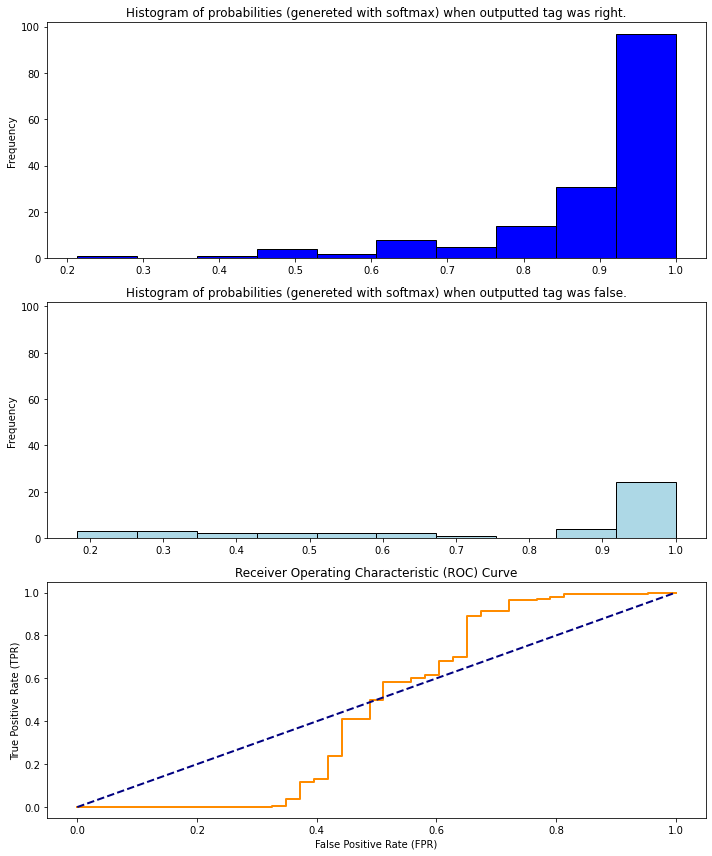

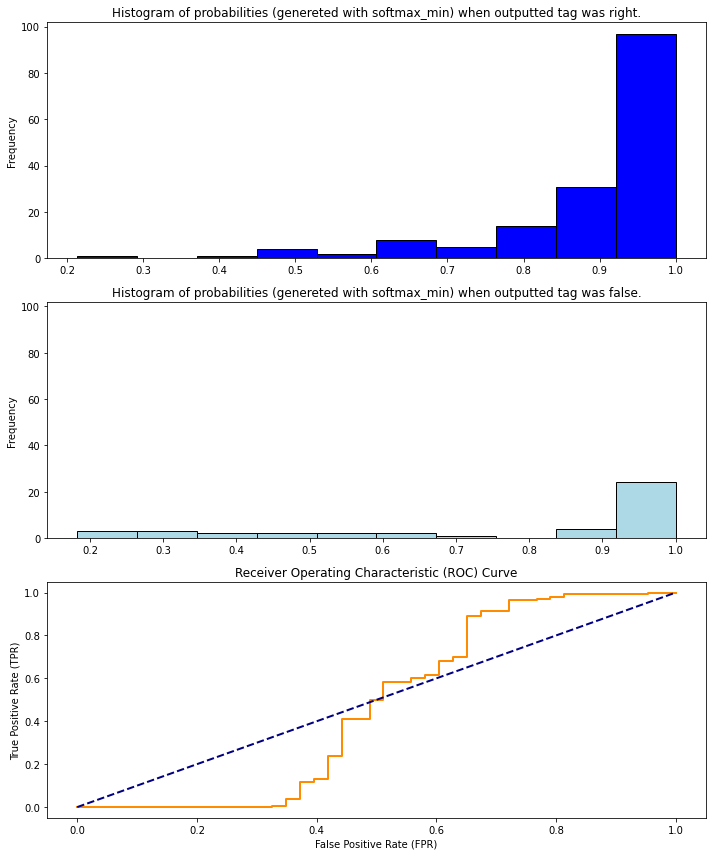

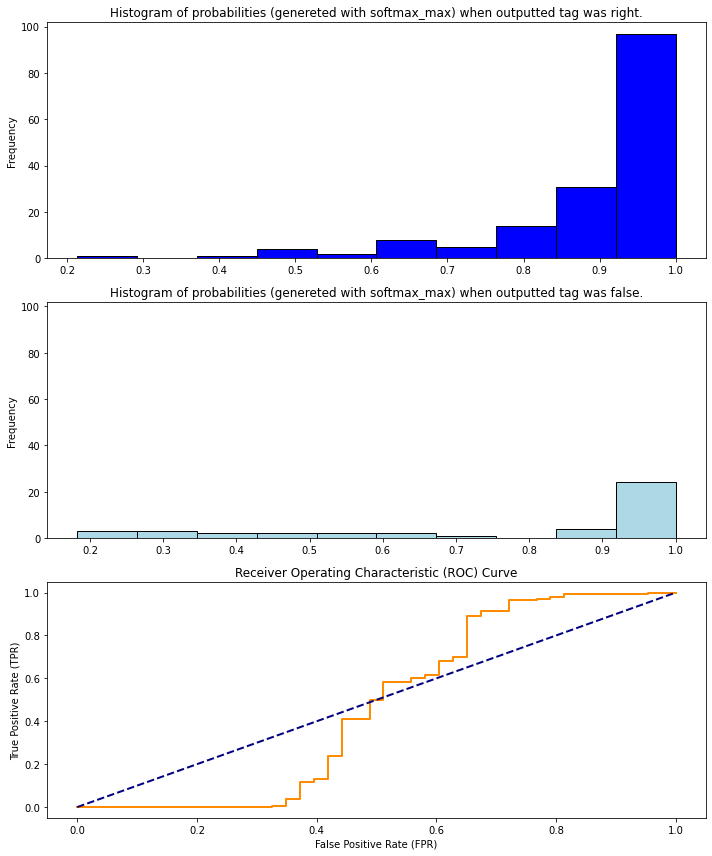

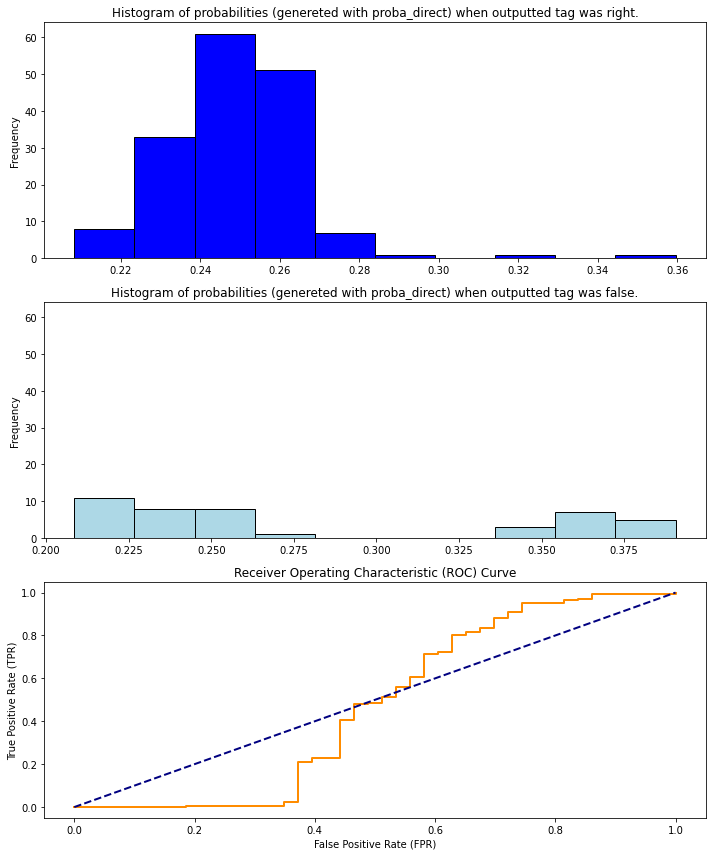

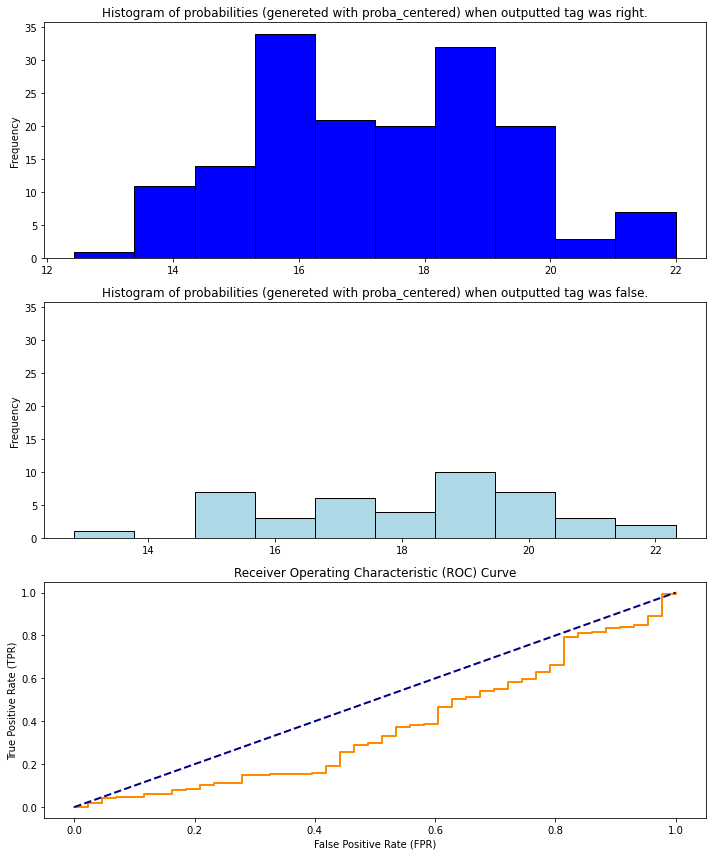

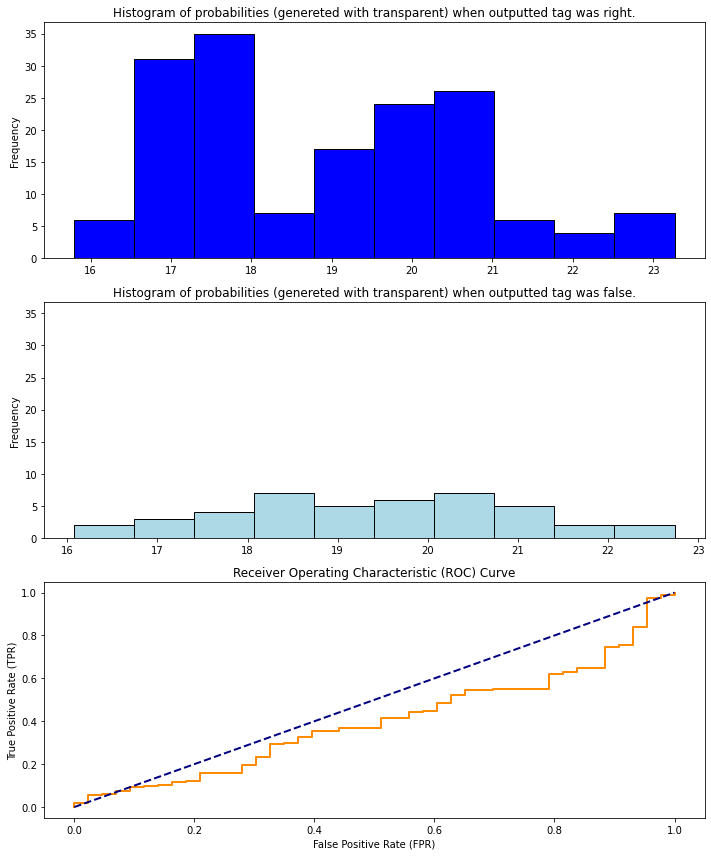

In [74]:
show_confidence()

In [18]:
for dp in all_data:
    for ent in dp['logits_for_tags'] :
        ent = add_confidence_to_results(ent)

# Descriptions for Realys Ketl 

In [14]:
len(small_descriptions), len(long_descriptions), len(fixed_values) # =43

fields_in_small_descr = [desc['field'] for desc in small_descriptions]
[val for val in fixed_values if not fields_in_small_descr]

[]

In [28]:
descriptions_to_override = [
  {
      "field": "_text.Mandat",
      "description": "Document formel conférant à une personne le pouvoir d'agir au nom d'une autre dans des situations spécifiques, souvent utilisé dans des transactions immobilières ou juridiques."
  },
  {
      "field": "_text.Garantie de loyer",
      "description": "Engagement financier fournissant une garantie financière à un bailleur, souvent requis lors de la location d'un bien immobilier."
  },
  {
      "field": "_text.Formulaire établissement garantie bancaire",
      "description": "Formulaire officiel utilisé pour établir une garantie bancaire, souvent nécessaire dans le cadre de transactions immobilières ou locatives."
  },
  {
      "field": "_text.Avis de Crédit garantie loyer",
      "description": "Avis officiel informant sur la vérification de crédit pour l'établissement d'une garantie de loyer, généralement dans le contexte de locations immobilières."
  },
  {
      "field": "_text.Contrat de garantie de loyer",
      "description": "Contrat formel spécifiant les termes et conditions de la garantie de loyer, établissant les obligations entre le locataire et le bailleur."
  },
  {
      "field": "_text.Assurance",
      "description": "Document ou certificat établissant la couverture et les conditions d'une police d'assurance, décrivant les garanties et les responsabilités."
  },
  {
      "field": "_text.Hypothèque",
      "description": "Document juridique établissant un droit de garantie sur un bien immobilier, souvent utilisé dans le cadre de prêts hypothécaires."
  },
  {
      "field": "_text.Etat des lieux",
      "description": "Document détaillant l'état physique d'un appartement avant et après une location, enregistrant les éventuels dommages ou modifications."
  },
  {
      "field": "_text.Plan",
      "description": "Dessin ou document graphique décrivant la disposition d'un lieu, souvent utilisé dans le cadre de transactions immobilières ou de constructions."
  },
  {
      "field": "_text.Devis",
      "description": "Document détaillant les coûts estimés pour des biens ou services spécifiques, soumis avant la conclusion d'une transaction ou d'un contrat."
  },
  {
      "field": "_text.Facture",
      "description": "Document récapitulatif des coûts ou montants dus pour des biens ou services fournis, émis par un fournisseur ou prestataire de services."
  },
  {
      "field": "_text.Contrat",
      "description": "Document légal détaillant les termes et conditions d'un accord formel entre parties, établissant les droits et obligations mutuels."
  },
  {
      "field": "_text.Contrat de bail",
      "description": "Contrat spécifiant les conditions de location d'un bien immobilier, décrivant les droits et responsabilités du locataire et du bailleur."
  },
  {
      "field": "_text.Procès verbal",
      "description": "Document détaillant les procédures et les décisions prises lors d'une réunion ou d'un événement particulier, souvent utilisé dans un contexte juridique ou administratif."
  },
  {
      "field": "_text.Compte de gestion",
      "description": "Document financier récapitulant les transactions et les mouvements de fonds, généralement utilisé dans la gestion de biens ou de comptes spécifiques."
  },
  {
      "field": "_text.Rapport de mise en valeur",
      "description": "Rapport détaillant les améliorations apportées à un bien immobilier, souvent utilisé dans le contexte de l'évaluation immobilière ou de la gestion immobilière."
  },
  {
      "field": "_text.Acomptes de charges",
      "description": "Document détaillant les acomptes ou paiements anticipés pour les charges liées à un bien immobilier, souvent utilisé dans le cadre de la gestion immobilière."
  },
  {
      "field": "_text.Chargé de pièce",
      "description": "Document officiel décrivant la constitution d'un objet immobilier, les différents biens qu'il contient."
  },
  {
      "field": "_text.Cahier des charges",
      "description": "Document détaillant les spécifications et les exigences pour un projet ou un service spécifique, utilisé dans le cadre de contrats ou d'appels d'offres."
  },
  {
      "field": "_text.Certificat médical",
      "description": "Document médical officiel délivré par un professionnel de la santé, confirmant un état de santé spécifique ou une condition médicale."
  },
  {
      "field": "_text.Lettre",
      "description": "Document écrit formel transmis ou reçu, contient aussi toutes les communications officielles entre une régie et ses locataires."
  },
  {
      "field": "_text.E-mail",
      "description": "Communication électronique écrite transmise par courrier électronique entre parties, souvent utilisée pour la correspondance rapide."
  },
  {
      "field": "_text.Fiche de salaire",
      "description": "Document détaillant les éléments de la rémunération d'un employé pour une période donnée, incluant les salaires, avantages et retenues."
  },
  {
      "field": "_text.Décompte de chauffage",
      "description": "Document détaillant les coûts ou la consommation de chauffage, souvent utilisé dans le cadre de la gestion immobilière."
  },
  {
      "field": "_text.Clé de répartition",
      "description": "Document spécifiant la méthode de répartition des coûts ou des charges entre parties, généralement utilisé dans un contexte immobilier."
  },
  {
      "field": "_text.Etat locatif",
      "description": "Document détaillant les caractéristiques et l'état d'un bien immobilier, souvent utilisé dans le contexte de la location ou de la gestion immobilière."
  },
  {
      "field": "_text.Fonctionnement chaufferie",
      "description": "Document décrivant les procédures et les opérations liées au fonctionnement d'une chaufferie, souvent utilisé dans le contexte de l'énergie et du chauffage."
  },
  {
      "field": "_text.Formulaire d'inscription locataire",
      "description": "Formulaire officiel utilisé par les locataires pour s'inscrire ou postuler à la location d'un bien immobilier, fournissant des informations personnelles et financières."
  },
  {
      "field": "_text.Demande d'établissement de bail",
      "description": "Demande formelle pour l'établissement d'un contrat de bail, généralement soumise par un locataire potentiel au propriétaire."
  },
  {
      "field": "_text.Avis de fixation",
      "description": "Avis officiel indiquant une fixation ou détermination spécifique, souvent utilisé dans le contexte de la régulation des loyers ou des tarifs."
  },
  {
      "field": "_text.Formulaire commande plaquettes",
      "description": "Formulaire de commande de plaquettes"
  },
  {
      "field": "_text.Formulaire reprise locataire",
      "description": "Formulaire de reprise de bail par un locataire"
  },
  {
      "field": "_text.Extrait du registre des poursuites",
      "description": "Extrait du registre des poursuites"
  },
  {
      "field": "_text.Attestation de remise des clés",
      "description": "Attestation de remise des clés"
  },
  {
      "field": "_text.Photo",
      "description": "Document de type image"
  }
]

small_descriptions = [
  {
    "field": "_text.Annonce incapacité",
    "description": "Document d'annonce lié à l'incapacité, potentiellement lié à la santé ou à l'invalidité d'un employé."
  },
  {
    "field": "_text.Appels d'offres",
    "description": "Documents liés à des appels d'offres ou à des soumissions, souvent utilisés dans des processus d'approvisionnement."
  },
  {
    "field": "_text.Attestation",
    "description": "Certificat ou déclaration confirmant un fait ou un événement."
  },
  {
    "field": "_text.Attestation LPP",
    "description": "Certificat ou déclaration lié à la LPP (Loi sur la prévoyance professionnelle) en Suisse."
  },
  {
    "field": "_text.Décompte de prestations",
    "description": "Déclaration ou détail des services ou prestations fournis."
  },
  {
    "field": "_text.Contrats",
    "description": "Documents de contrat détaillant des accords ou des arrangements entre des parties."
  },
  {
    "field": "_text.Convention",
    "description": "Accord ou traité formel, souvent utilisé dans des contextes juridiques."
  },
  {
    "field": "_text.Correspondance",
    "description": "Correspondance ou documents de communication générale."
  },
  {
    "field": "_text.Déclaration annuelle",
    "description": "Déclaration annuelle ou document de bilan annuel."
  },
  {
    "field": "_text.Déclaration de sinistre",
    "description": "Document lié à la déclaration d'une réclamation d'assurance ou d'un incident."
  },
  {
    "field": "_text.Décompte de commissions",
    "description": "Déclaration ou détail des commissions."
  },
  {
    "field": "_text.Décompte de prime",
    "description": "Déclaration ou détail des primes d'assurance."
  },
  {
    "field": "_text.Décompte IJ",
    "description": "Déclaration ou détail des 'Indemnités Journalières'."
  },
  {
    "field": "_text.Décompte Libération",
    "description": "Déclaration ou document lié à la libération ou à la libération de quelque chose."
  },
  {
    "field": "_text.E-mails",
    "description": "Documents liés à la communication électronique par courrier électronique."
  },
  {
    "field": "_text.Factures honoraires",
    "description": "Factures pour les honoraires professionnels ou les services."
  },
  {
    "field": "_text.Mandat",
    "description": "Document accordant à quelqu'un l'autorité ou la procuration."
  },
  {
    "field": "_text.Mutations",
    "description": "Documents liés à des changements ou mutations, souvent dans le contexte du personnel ou des dossiers."
  },
  {
    "field": "_text.Offres",
    "description": "Offres ou propositions soumises en réponse à une demande."
  },
  {
    "field": "_text.Participation aux excédents",
    "description": "Documents liés à la participation aux excédents, souvent dans des contextes d'assurance."
  },
  {
    "field": "_text.Police",
    "description": "Documents de police d'assurance."
  },
  {
    "field": "_text.Procuration",
    "description": "Document accordant à quelqu'un le pouvoir ou la procuration."
  },
  {
    "field": "_text.Proposition signée",
    "description": "Proposition ou offre signée."
  },
  {
    "field": "_text.Rappel de prime",
    "description": "Document de rappel lié aux primes d'assurance."
  },
  {
    "field": "_text.Règlement",
    "description": "Documents de règlement ou de règles."
  },
  {
    "field": "_text.Règlement de prévoyance",
    "description": "Règlements ou règles liés aux fonds de prévoyance ou aux avantages."
  },
  {
    "field": "_text.Cotisations",
    "description": "Document de contributions ou de cotisations."
  },
  {
    "field": "_text.Rendement",
    "description": "Documents liés à la performance ou au rendement, souvent dans des contextes financiers."
  },
  {
    "field": "_text.Suivi",
    "description": "Documents de suivi ou d'enregistrements."
  },
  {
    "field": "_text.Suivi incapacité",
    "description": "Documents de suivi liés à l'incapacité ou à l'invalidité."
  },
  {
    "field": "_text.Relevé de compte",
    "description": "Document de relevé de compte."
  },
  {
    "field": "_text.Commission de prévoyance",
    "description": "Documents liés à la commission des fonds de prévoyance."
  },
  {
    "field": "_text.Contrat d'adhésion",
    "description": "Document de contrat d'adhésion ou d'inscription."
  },
  {
    "field": "_text.Plan de prévoyance",
    "description": "Document de plan de prévoyance ou d'avantages."
  },
  {
    "field": "_text.Demande de subside",
    "description": "Demande d'aide financière ou de subvention."
  },
  {
    "field": "_text.Décompte définitif",
    "description": "Déclaration ou détail final."
  },
  {
    "field": "_text.Confirmation d'octroi subside",
    "description": "Confirmation de l'approbation d'une subvention."
  },
  {
    "field": "_text.Décompte d'annulation",
    "description": "Déclaration ou détail d'annulation."
  },
  {
    "field": "_text.Certificat médical",
    "description": "Document de certificat médical."
  },
  {
    "field": "_text.Factures",
    "description": "Factures ou documents de facturation."
  },
  {
    "field": "_text.Devis",
    "description": "Devis ou document d'estimation."
  },
  {
    "field": "_text.Avenant",
    "description": "Amendement ou addendum à un contrat ou accord."
  },
  {
    "field": "_text.Questionnaire",
    "description": "Document de questionnaire."
  }
]


long_descriptions = [
  {
    "field": "_text.Annonce incapacité",
    "description": "Annonce de l'incapacité d'un employé, généralement liée à des problèmes de santé ou d'invalidité."
  },
  {
    "field": "_text.Appels d'offres",
    "description": "Documents liés aux processus d'appels d'offres ou de soumissions pour des contrats ou projets spécifiques."
  },
  {
    "field": "_text.Attestation",
    "description": "Certificat ou déclaration officielle confirmant un fait, une compétence ou un statut spécifique."
  },
  {
    "field": "_text.Attestation LPP",
    "description": "Certificat ou déclaration lié à la Loi sur la prévoyance professionnelle (LPP) en Suisse, souvent utilisé dans le contexte des régimes de retraite professionnelle."
  },
  {
    "field": "_text.Décompte de prestations",
    "description": "Document détaillant les services ou prestations fournis, souvent utilisé dans les secteurs des soins de santé ou de l'assurance."
  },
  {
    "field": "_text.Contrats",
    "description": "Documents officiels décrivant les accords ou contrats formels entre parties, spécifiant les termes et conditions."
  },
  {
    "field": "_text.Convention",
    "description": "Accord formel entre parties, souvent utilisé dans des contextes juridiques ou diplomatiques."
  },
  {
    "field": "_text.Correspondance",
    "description": "Documents liés à la communication écrite, tels que des lettres, courriels ou notes."
  },
  {
    "field": "_text.Déclaration annuelle",
    "description": "Déclaration officielle soumise annuellement, décrivant généralement des informations financières, fiscales ou autres."
  },
  {
    "field": "_text.Déclaration de sinistre",
    "description": "Document signalant un incident ou un sinistre, généralement utilisé dans le cadre des réclamations d'assurance."
  },
  {
    "field": "_text.Décompte de commissions",
    "description": "Document détaillant les commissions monétaires ou autres paiements associés à des transactions commerciales."
  },
  {
    "field": "_text.Décompte de prime",
    "description": "Document détaillant les coûts ou montants des primes d'assurance, généralement périodique."
  },
  {
    "field": "_text.Décompte IJ",
    "description": "Décompte des 'Indemnités Journalières', document spécifiant les paiements liés à des absences temporaires, souvent utilisé dans le contexte de l'assurance maladie."
  },
  {
    "field": "_text.Décompte Libération",
    "description": "Document détaillant la libération ou la libération de fonds, de biens ou d'autres ressources."
  },
  {
    "field": "_text.E-mails",
    "description": "Documents électroniques de communication par courrier électronique, incluant les échanges écrits entre parties."
  },
  {
    "field": "_text.Factures honoraires",
    "description": "Factures détaillant les honoraires professionnels ou les services fournis par des prestataires de services."
  },
  {
    "field": "_text.Mandat",
    "description": "Document conférant le pouvoir ou l'autorisation formelle à une personne pour agir au nom d'une autre."
  },
  {
    "field": "_text.Mutations",
    "description": "Documents liés aux changements, ajouts ou suppressions, souvent utilisés dans le contexte de la gestion des ressources humaines ou des bases de données."
  },
  {
    "field": "_text.Offres",
    "description": "Documents formels présentant des propositions, estimations ou offres en réponse à des demandes spécifiques."
  },
  {
    "field": "_text.Participation aux excédents",
    "description": "Documents liés à la participation aux excédents ou profits, souvent dans le contexte d'assurances ou de fonds de placement."
  },
  {
    "field": "_text.Police",
    "description": "Documents officiels énonçant les termes et conditions d'une police d'assurance, décrivant la couverture et les obligations."
  },
  {
    "field": "_text.Procuration",
    "description": "Document légal conférant à une personne le pouvoir d'agir au nom d'une autre, souvent utilisé pour des transactions spécifiques."
  },
  {
    "field": "_text.Proposition signée",
    "description": "Proposition ou offre officielle signée par une partie, indiquant l'engagement envers les conditions proposées."
  },
  {
    "field": "_text.Rappel de prime",
    "description": "Document rappelant le paiement d'une prime d'assurance, généralement envoyé avant la date d'échéance."
  },
  {
    "field": "_text.Règlement",
    "description": "Documents énonçant des règles ou des réglementations officielles, souvent utilisés dans des contextes juridiques ou institutionnels."
  },
  {
    "field": "_text.Règlement de prévoyance",
    "description": "Documents énonçant les règles et règlements spécifiques d'un régime de prévoyance ou de retraite."
  },
  {
    "field": "_text.Cotisations",
    "description": "Documents spécifiant les contributions financières requises, souvent dans le contexte d'organisations ou d'associations."
  },
  {
    "field": "_text.Rendement",
    "description": "Documents détaillant les performances financières ou opérationnelles d'un investissement, d'un projet ou d'une entreprise."
  },
  {
    "field": "_text.Suivi",
    "description": "Documents de suivi, enregistrements ou rapports permettant de suivre l'évolution d'une situation, d'un projet ou d'une performance."
  },
  {
    "field": "_text.Suivi incapacité",
    "description": "Documents de suivi spécifiques à l'incapacité, enregistrant l'évolution de la situation d'une personne en termes de santé ou d'invalidité."
  },
  {
    "field": "_text.Relevé de compte",
    "description": "Document fournissant un aperçu détaillé des transactions financières sur un compte spécifique sur une période donnée."
  },
  {
    "field": "_text.Commission de prévoyance",
    "description": "Documents liés à la commission des fonds de prévoyance, impliquant généralement des décisions et des recommandations sur les placements."
  },
  {
    "field": "_text.Contrat d'adhésion",
    "description": "Document formalisant l'adhésion ou l'inscription à un service, programme ou organisation spécifique."
  },
  {
    "field": "_text.Plan de prévoyance",
    "description": "Document détaillant les dispositions d'un plan de prévoyance ou de retraite, y compris les avantages et les modalités."
  },
  {
    "field": "_text.Demande de subside",
    "description": "Document soumis pour solliciter une assistance financière ou un subside, fournissant des détails sur la justification de la demande."
  },
  {
    "field": "_text.Décompte définitif",
    "description": "Document présentant un décompte final, souvent utilisé pour clore un projet ou une transaction."
  },
  {
    "field": "_text.Confirmation d'octroi subside",
    "description": "Document confirmant l'approbation et l'octroi d'un subside financier, souvent utilisé dans le contexte de subventions gouvernementales."
  },
  {
    "field": "_text.Décompte d'annulation",
    "description": "Document détaillant l'annulation de charges, frais ou obligations financières."
  },
  {
    "field": "_text.Certificat médical",
    "description": "Document médical officiel délivré par un professionnel de la santé, confirmant un état de santé spécifique ou une condition médicale."
  },
  {
    "field": "_text.Factures",
    "description": "Documents officiels énumérant les coûts et détails des biens ou services fournis, généralement utilisés pour la facturation."
  },
  {
    "field": "_text.Devis",
    "description": "Document formel fournissant une estimation détaillée des coûts pour des biens ou services spécifiques, généralement utilisé avant la conclusion d'une transaction."
  },
  {
    "field": "_text.Avenant",
    "description": "Amendement ou ajout officiel à un contrat ou à un accord existant, spécifiant des modifications ou des ajouts aux termes d'origine."
  },
  {
    "field": "_text.Questionnaire",
    "description": "Document comprenant des questions structurées, utilisé pour recueillir des informations spécifiques, souvent dans le cadre d'enquêtes ou d'évaluations."
  }
]


In [23]:
fixed_values_to_override =  [
        "_text.Mandat",
        "_text.Garantie de loyer",
        "_text.Formulaire établissement garantie bancaire",
        "_text.Avis de Crédit garantie loyer",
        "_text.Contrat de garantie de loyer",
        "_text.Assurance",
        "_text.Hypothèque",
        "_text.Etat des lieux",
        "_text.Plan",
        "_text.Devis",
        "_text.Facture",
        "_text.Contrat",
        "_text.Contrat de bail",
        "_text.Procès verbal",
        "_text.Compte de gestion",
        "_text.Rapport de mise en valeur",
        "_text.Acomptes de charges",
        "_text.Chargé de pièce",
        "_text.Cahier des charges",
        "_text.Certificat médical",
        "_text.Lettre",
        "_text.E-mail",
        "_text.Fiche de salaire",
        "_text.Décompte de chauffage",
        "_text.Clé de répartition",
        "_text.Etat locatif",
        "_text.Fonctionnement chaufferie",
        "_text.Formulaire d'inscription locataire",
        "_text.Demande d'établissement de bail",
        "_text.Avis de fixation"
    ]

In [30]:
len(descriptions_to_override), len(fixed_values_to_override) # = 30
fields_in_descr = [val['field'] for val in descriptions_to_override]
[val for val in fixed_values_to_override if val not in fields_in_descr]

[]

In [25]:
long_descriptions = {descr['field'] : descr['description'] for descr in long_descriptions}

In [33]:
all_text = '\n'.join([f"{val['field'][6:]} : {val['description']}" for val in descriptions_to_override])
len(all_text)

4933

In [34]:
all_text # 1209 tokens, 4964 charactères

"Mandat : Document formel conférant à une personne le pouvoir d'agir au nom d'une autre dans des situations spécifiques, souvent utilisé dans des transactions immobilières ou juridiques.\nGarantie de loyer : Engagement financier fournissant une garantie financière à un bailleur, souvent requis lors de la location d'un bien immobilier.\nFormulaire établissement garantie bancaire : Formulaire officiel utilisé pour établir une garantie bancaire, souvent nécessaire dans le cadre de transactions immobilières ou locatives.\nAvis de Crédit garantie loyer : Avis officiel informant sur la vérification de crédit pour l'établissement d'une garantie de loyer, généralement dans le contexte de locations immobilières.\nContrat de garantie de loyer : Contrat formel spécifiant les termes et conditions de la garantie de loyer, établissant les obligations entre le locataire et le bailleur.\nAssurance : Document ou certificat établissant la couverture et les conditions d'une police d'assurance, décrivant 

In [36]:
a = [1,5,3,6]
sorted(a)

[1, 3, 5, 6]